In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

## Source
https://www.kaggle.com/jtiptj/chest-xray-pneumoniacovid19tuberculosis

In [2]:
TRAINDIR = r"C:\Users\Tommy\Documents\Jupyter Notebooks\Lung Disease\lung_disease\train"
VALIDDIR = r"C:\Users\Tommy\Documents\Jupyter Notebooks\Lung Disease\lung_disease\val"
TESTDIR = r"C:\Users\Tommy\Documents\Jupyter Notebooks\Lung Disease\lung_disease\test"

CATEGORIES = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

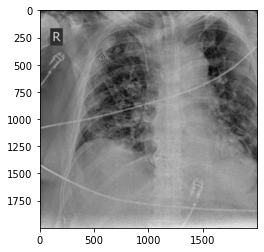

In [3]:
for category in CATEGORIES:
    path = os.path.join(TRAINDIR, category)
    for img  in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

In [4]:
print(img_array.shape)

(2000, 2000)


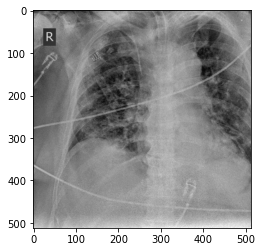

In [5]:
IMG_SIZE = 512

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')

In [6]:
new_array.shape

(512, 512)

In [7]:
# create training data
def create_training_data():
    training_data = []
    
    for category in CATEGORIES:
        path = os.path.join(TRAINDIR, category)
        class_num = CATEGORIES.index(category)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])

    print(f'length of training data: {len(training_data)}')
    random.shuffle(training_data)
    
    return training_data

In [9]:
training_data = create_training_data()

length of training data: 6326


In [10]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [38]:
pickle_out = open('grayscale_lungs_training.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('grayscale_lungs_training_labels.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()

In [8]:
X = pickle.load(open('grayscale_lungs_training.pickle', 'rb'))
y = np.array(pickle.load(open('grayscale_lungs_training_labels.pickle', 'rb')))

In [9]:
X = X[:1000]
y = y[:1000]

X = X/255.0
y = to_categorical(y, 4)

In [10]:
# creating validation set
def create_validation_data():
    validation_data = []
    
    for category in CATEGORIES:
        path = os.path.join(VALIDDIR, category)
        class_num = CATEGORIES.index(category)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            validation_data.append([new_array, class_num])

    print(f'length of validation data: {len(validation_data)}')
    random.shuffle(validation_data)
    
    return validation_data

In [11]:
validation_data = create_validation_data()

length of validation data: 38


In [12]:
X_val = []
y_val = []

for features, label in validation_data:
    X_val.append(features)
    y_val.append(label)
    
X_val = np.array(X_val).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

X_val = X_val / 255.0
y_val = to_categorical(y_val, 4)

In [13]:
# creating test set
def create_test_data():
    test_data = []
    
    for category in CATEGORIES:
        path = os.path.join(TESTDIR, category)
        class_num = CATEGORIES.index(category)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])

    print(f'length of test data: {len(test_data)}')
    random.shuffle(test_data)
    
    return test_data

In [14]:
test_data = create_test_data()

length of test data: 771


In [15]:
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)
    
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

X_test = X_test / 255.0
y_test = to_categorical(y_test, 4)

## Convolutional Neural Network

In [16]:
early_stopper = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=3)

In [17]:
model = Sequential()

model.add(Conv2D(32, (2,2), input_shape=X.shape[1:], activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 255, 255, 32)      4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 516128)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                16516128  
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5

In [156]:
with tf.device('/CPU:0'):
    model.fit(X, y, batch_size=100, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopper])

Epoch 1/50
10/10 [==============================] - 123s 11s/step - loss: 2.9897 - accuracy: 0.4970 - val_loss: 1.4202 - val_accuracy: 0.4737
Epoch 2/50
10/10 [==============================] - 105s 11s/step - loss: 0.9436 - accuracy: 0.6410 - val_loss: 1.4090 - val_accuracy: 0.2632
Epoch 3/50
10/10 [==============================] - 107s 11s/step - loss: 0.6882 - accuracy: 0.7180 - val_loss: 1.0786 - val_accuracy: 0.4737
Epoch 4/50
10/10 [==============================] - 104s 10s/step - loss: 0.4601 - accuracy: 0.8420 - val_loss: 0.8002 - val_accuracy: 0.7105
Epoch 5/50
10/10 [==============================] - 108s 11s/step - loss: 0.3203 - accuracy: 0.8860 - val_loss: 0.8161 - val_accuracy: 0.7368
Epoch 6/50
10/10 [==============================] - 108s 11s/step - loss: 0.2628 - accuracy: 0.9070 - val_loss: 0.6696 - val_accuracy: 0.6579
Epoch 7/50
10/10 [==============================] - 108s 11s/step - loss: 0.1975 - accuracy: 0.9410 - val_loss: 0.4012 - val_accuracy: 0.8684
Epoch 

<AxesSubplot:>

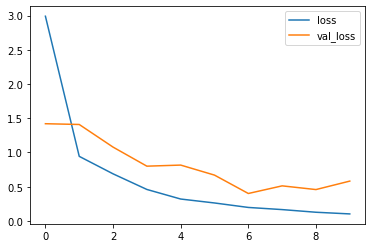

In [157]:
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()

In [22]:
with tf.device('/cpu:0'):
    predictions = np.argmax(load_model.predict(X_test), axis=1)

In [20]:
y_test = np.argmax(y_test, axis=1)

In [161]:
print('Classification Report')
print(classification_report(y_true=y_test, y_pred=predictions, target_names=CATEGORIES))

Classification Report
              precision    recall  f1-score   support

     COVID19       0.82      0.82      0.82       106
      NORMAL       0.95      0.60      0.74       234
   PNEUMONIA       0.82      0.98      0.90       390
TUBERCULOSIS       0.80      0.95      0.87        41

    accuracy                           0.84       771
   macro avg       0.85      0.84      0.83       771
weighted avg       0.86      0.84      0.84       771



[[ 87   3   7   9]
 [ 17 141  76   0]
 [  1   4 384   1]
 [  1   0   1  39]]


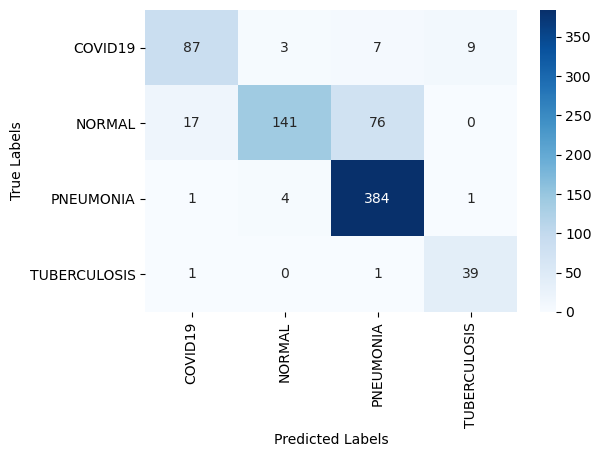

In [167]:
print(confusion_matrix(y_test, predictions))

plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, predictions),
            xticklabels=CATEGORIES, yticklabels=CATEGORIES, 
            cmap='Blues', annot=True, fmt='.3g')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [165]:
# model.save('lung_disease_detection_model_2.h5')

In [19]:
load_model = tf.keras.models.load_model('lung_disease_detection_model_2.h5')

In [23]:
test_data_8 = test_data[:8]
predictions_8 = predictions[:8]

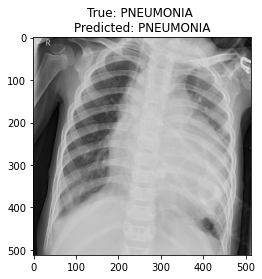

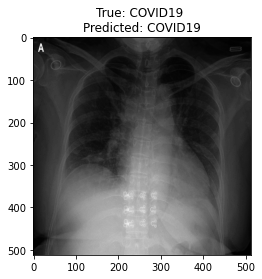

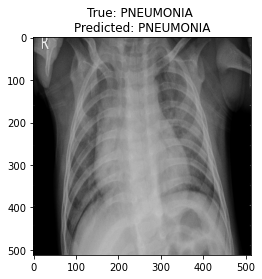

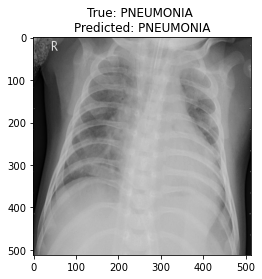

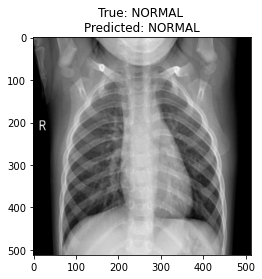

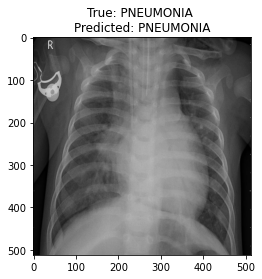

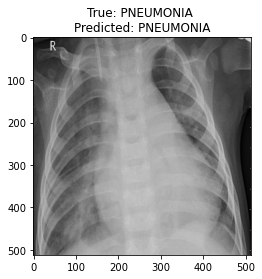

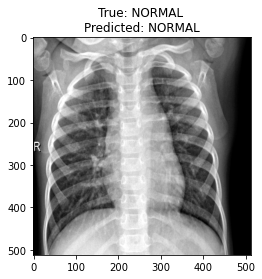

In [25]:
for i, data in enumerate(test_data_8):
    plt.imshow(data[0], cmap='gray')
    plt.title(f'True: {CATEGORIES[data[1]]} \nPredicted: {CATEGORIES[predictions_8[i]]}')
    plt.show()